# Tutorial: truss structures

**NOTE:**
In the package, all the core FEA functions make a distinction of the elements (and so in the procedure to be used and eventual corrections to be applied) **based on the number of DOFs** of the element. 

This represents a problem now, since the bar element has technically 1 dof but, if it is used for truss structures, its rotation in the x-y plane causes the nodes to move both in x and y directions. So in this case, the nodes have 2 dofs with respect to the global coordinate system. The same number of dofs as the simple beam element.

**HOW TO USE TRUSS ELEMENTS FOR 2D STRUCTURES:**

Given the observation above, we can say that when used in 2D structures, the bar element has 2 dofs per node. So:
- in the pre and post processing phases, set the number of dofs per node (ndof_per_node) to 2, since we are dealing with 2D geometries
- during the core FEA calculations (all the functions in the submodule fem_toolbox.femsolver), set the ndof_per_node = 1, without forgetting to pass the functions the rotation matrix. Doing this, the functions will recognize that they need to adapt the procedures of the bar element for a 2D case

*!!! Use 1 element per beam for the discretization, otherwise the stiffness matrix will present singularities. Since the axial stress varies linearly in the beam, using only 1 element still yields the correct solution*


### PREPROCESSING

Using bar elements (1 DOF), but in a 2D geometry. So set ndof_per_node = 2
Using elements_per_beam = 1, otherwise K will be singular (intermediate nodes float around since they do not have y and rotation constraints)

  __                _              _ _               
 / _|              | |            | | |              
| |_ ___ _ __ ___  | |_ ___   ___ | | |__   _____  __
|  _/ _ \ '_ ` _ \ | __/ _ \ / _ \| | '_ \ / _ \ \/ /
| ||  __/ | | | | || || (_) | (_) | | |_) | (_) >  < 
|_| \___|_| |_| |_| \__\___/ \___/|_|_.__/ \___/_/\_\
                ______                               
               |______|                              

github.com/Gabbbri/fem_toolbox


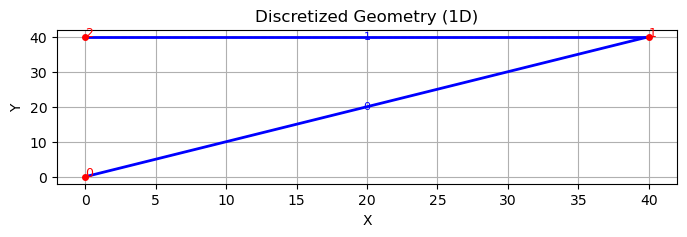

Constraint check passed: 4 DOFs constrained out of 6.


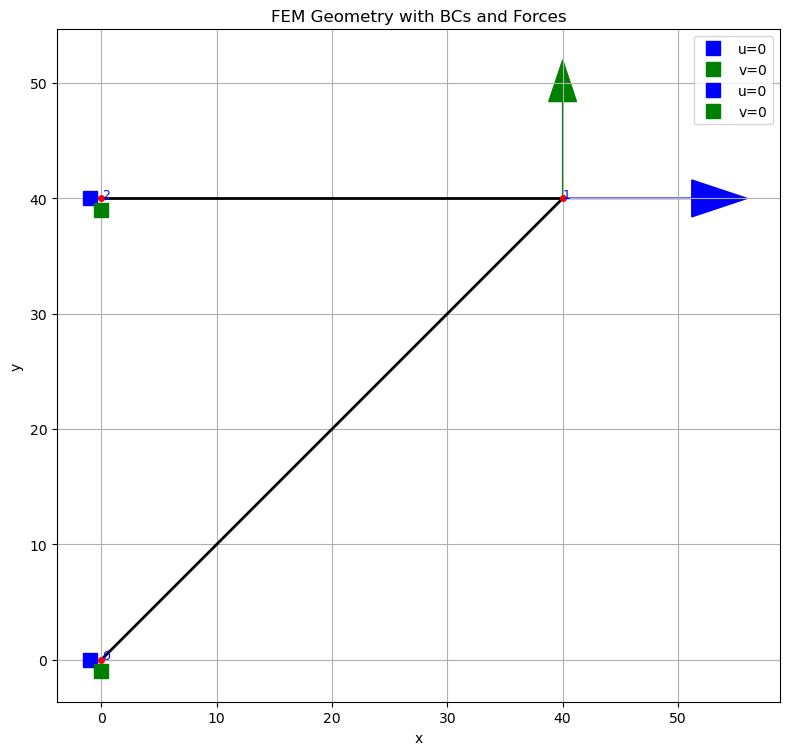

In [1]:
import fem_toolbox as ft

# read geometry

nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = ft.geometry.read_structure("../Tutorials/geometry&boundary-files/trussframe.txt")

# meshing
elements_per_beam = 1   

fem_nodes, fem_elements, element_crossSections = ft.mesh.discretize(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=elements_per_beam)

ft.mesh.plot_discretized_geometry_1D(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

# even if using truss elements (1 dof per node), we have a 2d structure, so in the global reference system there will be 2 dofs per node. The stiffness of the element will be only axial though
ndof_per_node = 2

# BC and forces
_ , bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = ft.BC_loads.read_bc_and_forces("../Tutorials/geometry&boundary-files/trussBC.txt")

# validate constraints (read docs)
num_nodes= fem_nodes.shape[0]
ft.BC_loads.validate_constraints(num_nodes, ndof_per_node, bc_nodes, bc_dofs)

# visual validation before solving 
ft.BC_loads.plot_fem_model(fem_nodes, fem_elements, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, scale_force=0.02)


## SOME THEORY: Modeling Truss Structures with Bar Elements

### Can a single truss member be discretized using **multiple bar elements**?

#### Yes — but only when necessary

Bar elements are designed to model **axial deformation only**. Discretizing a straight truss member into multiple bar elements is:

- **Valid** in theory: It still correctly models axial forces and elongation.
-  **Usually unnecessary** in practice:
  - Axial strain in a uniform bar is **linear**, so subdividing gives no extra accuracy.
  - You add:
    - More DOFs
    - Increased assembly complexity
    - Greater chance of numerical instability

#### When *is* it appropriate?

Use multiple bar elements **only if**:
- The member has **varying material properties** or **cross-sectional area**
- You are doing **gradient-based optimization** or **sensitivity analysis**
- You're modeling **nonlinear behavior**, **local damage**, or **fracture propagation**

#### When *not* to discretize further

Avoid breaking a truss member into multiple elements when:
- The member is **straight**, **homogeneous**, and **uniform**
- You're doing **linear static analysis**
- There is **no material or geometric variation** along the member

#### Best Practice

- Use **one bar element per physical truss member**
- Ensure:
  - Nodes are placed **only at physical joints**
  - Joints are **pinned** (no bending moment transfer)




## Behaviour of eventual intermediate nodes in truss structures with bar elements

#### Bar Element Behavior

Bar elements (also called truss elements) only support **axial deformation**:
- Only **1 DOF per node**: displacement **along the bar's axis**
- No resistance to:
  - Bending
  - Shear
  - Rotations

#### Discretizing a Truss with Multiple Bar Elements

If you model a **single truss member** using **multiple bar elements**, you introduce **internal nodes**. These nodes:
- Have **axial DOFs** only (aligned with each element)
- Cannot resist moments or shear
- Cannot maintain straightness under transverse loads **unless carefully constrained**

#### Problem with Transverse Forces

Suppose you apply a **vertical force** at the end of an inclined truss member:
- If that member is discretized with multiple bar elements:
  - Intermediate nodes have only axial DOFs
  - There is **no rotational stiffness**
  - The structure will deform **unphysically** (e.g., hinge-like motion)

### Physical Interpretation

In a real **pinned truss**:
- Joints only carry axial forces
- All transverse forces are carried **by the axial component** of connected bars
- A vertical load at the end of an inclined member **must be transferred via geometry**, not via moment

But if you have **intermediate nodes** with no extra support:
- There is nothing to balance the transverse component at those nodes
- The global stiffness matrix becomes **singular** or allows non-physical modes


## FEA ANALYSIS

Here call all the functions with ndof_per_node = 1, and remembering to give the reference to the rotation matrix. Only in this way the functions can understand that they are dealing with a truss 2D structure

In [2]:
# assemble global mass matrix rod
local_m_matrix = ft.elements.m_rod
local_k_matrix = ft.elements.k_rod
rotation_matrix = ft.elements.rotation_2d

ndof_per_node = 1   # truss element

K_global = ft.femsolver.assembleK(local_k_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)

# uncomment if you have simpy installed (just for visualization)
import sympy as sy
display(sy.Matrix(K_global))

Matrix([
[ 353553.390593274,  353553.390593274, -353553.390593274, -353553.390593274,         0, 0],
[ 353553.390593274,  353553.390593274, -353553.390593274, -353553.390593274,         0, 0],
[-353553.390593274, -353553.390593274,  1103553.39059327,  353553.390593274, -750000.0, 0],
[-353553.390593274, -353553.390593274,  353553.390593274,  353553.390593274,         0, 0],
[                0,                 0,         -750000.0,                 0,  750000.0, 0],
[                0,                 0,                 0,                 0,         0, 0]])

Note in the function "build_force_vector" the extra parameters fiven here: struct2D_trussElements=True. This is necesssary since this particular function, not working with rotation matrices or boundary conditions, has no other mean to understand if we are dealing with truss structures

In [3]:
# assemble global force vector
num_dofs = K_global.shape[0]
print(num_dofs)
f_ext = ft.femsolver.build_force_vector(f_nodes, f_dofs, f_values, num_dofs, ndof_per_node, struct2D_trussElements=True)
#display(sy.Matrix(f_ext))

6


In [4]:
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

In [5]:
# solving for displacements
u = ft.femsolver.static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values, ndof_per_node)

print(u)

[0.         0.         0.00026667 0.00143039 0.         0.        ]


In [6]:
# solving for frequencies -> only 2 elements, so we expect only 2 modes

M_global = ft.femsolver.assembleM(local_m_matrix, rotation_matrix, fem_nodes, fem_elements, element_crossSections, mat_properties, ndof_per_node)
print(M_global.shape)

frequencies, mode_shapes, free_dofs = ft.femsolver.modal_analysis(K_global, M_global, bc_nodes, bc_dofs, ndof_per_node, num_modes=5, verbose=True)

(6, 6)
Mode 1: 29.12 Hz
Mode 2: 41.19 Hz


## POST PROCESSING

Here we need again to switch to ndof_per_node = 2, as explained above

In [7]:
# post processing stresses
cross_section = "rectangle"

stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = ft.postprocessing.eval_stress(ft.elements.k_rod, ft.elements.rotation_2d, u,fem_elements, fem_nodes, element_crossSections, mat_properties, cross_section, ndof_per_node=1)

print(stress_max)
print(stress_axial)
print(stress_bending)
print(stress_shear)

reactions, _ = ft.postprocessing.compute_reaction_forces(K_global, u, bc_nodes, bc_dofs, ndof_per_node)


[212.13203436  66.66666667]
[212.13203436  66.66666667]
[]
[]
DOF 0: Reaction force = -600.00 N
DOF 1: Reaction force = -600.00 N
DOF 4: Reaction force = -200.00 N
DOF 5: Reaction force = 0.00 N


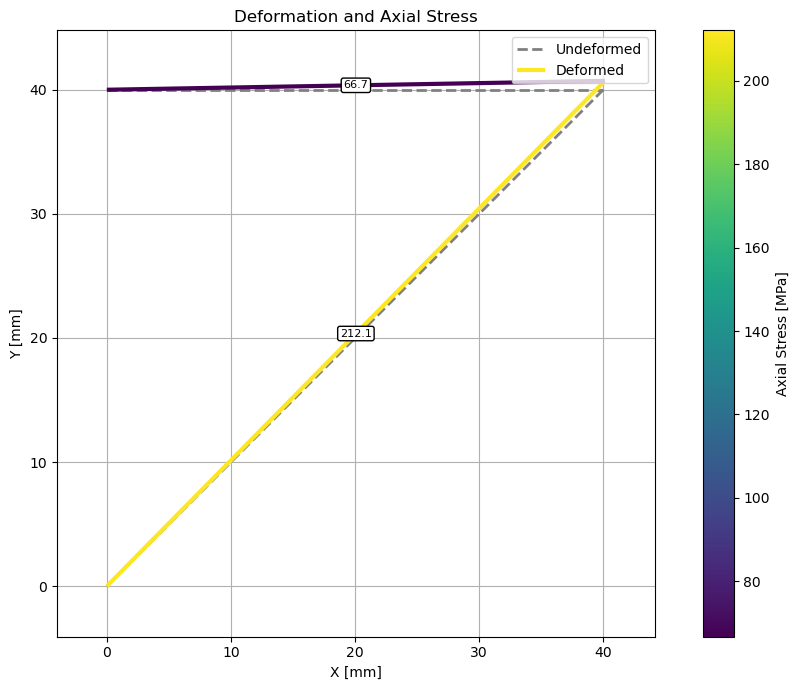

In [8]:
stress_type = "axial"
ft.postprocessing.plot_2D_loaded_structure(fem_nodes, fem_elements, u, stress_axial, stress_type, ndof_per_node=2, scale=500, show_labels=True)

### Internal actions plot
For trusses, the function used for plotting internal actions in beam elements doesn't work. An adaptation of it for bar elements doesn't seem time well spended, since the only internal action of a truss is, by definition, axial stress. The function fem_toolbox.postprocessing.plot_2D_loaded_structure provides an intuitive plot of the structure with its deformations and axial stresses in each element. 

In [9]:
# no internal actions plot, since using trusses we have only axial forces in the elements
#ft.postprocessing.plot_internal_actions_2D(beam_connectivity, fem_nodes, fem_elements, internal_actions, elements_per_beam=1)

In [10]:
ft.postprocessing.animate_mode_shape_2D(mode_index=0, eigenvecs=mode_shapes, node_coords=fem_nodes, free_dofs=free_dofs, K=K_global, elements=fem_elements, ndof_per_node=2, amplification=10)

## OPTIMIZATION

To have a look at the prototyping of the optimizer submodule, have a look at the subdirectory ./shape_optimization. Here is just some show-off of the actual capabilities

Specifically for trusses, some optimization methods can be found in the submodule 'fem_toolbox.optimizer'. Here there is the possibility to execute **weight minimization** (using *element areas as design variables*), based on 2 different criterias, namely constraint stress and constraint natural frequencies.


In [11]:
sigma_max = 100

optim_areas = ft.optimizer.optimize_crossSections4stress_trusses(element_crossSections, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, ft.elements.rotation_matrix_bar_2d, A_min=0.01)

print(optim_areas)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 559.9999999959318
            Iterations: 7
            Function evaluations: 22
            Gradient evaluations: 7
[8.48528137 2.        ]


In [12]:
ft.optimizer.checkOptimization_stresses_trusses(element_crossSections, optim_areas, sigma_max, fem_nodes, fem_elements, mat_properties, ndof_per_node, bc_nodes, bc_dofs, bc_values, f_ext, f_nodes, f_dofs, ft.femsolver.assembleK, ft.femsolver.build_force_vector, ft.elements.k_rod, ft.elements.rotation_matrix_bar_2d)

Element  | Area (orig) | Area (opt) | Stress (orig) | Stress (opt) | max_stress
---------|-------------|------------|----------------|----------------|----------
   0     |    4.00     |    8.49    |     212.13     |     100.00     |    100.00
   1     |    3.00     |    2.00    |     66.67      |     100.00     |    100.00


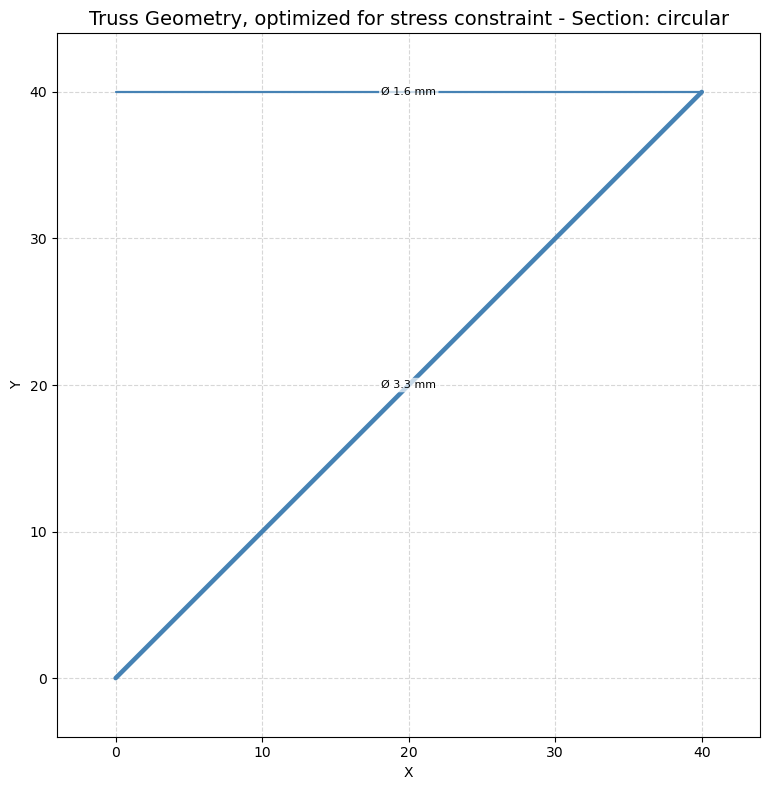

In [14]:
ft.optimizer.optim_plot_truss_geometry(fem_nodes, fem_elements, optim_areas, optim="stress", section_shape="circular", color="steelblue")